In [23]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule, ImputationDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.ops.imputation import add_missing_values
from tsl.engines import Imputer
from tsl.transforms import MaskInput
from tsl.nn.models import GRINModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
from tsl.metrics import torch as torch_metrics
import matplotlib.pyplot as plt
import torch


In [24]:
p_fault, p_noise = 0., 0.25
dataset = add_missing_values(MetrLA(),
                        p_fault=p_fault,
                        p_noise=p_noise,
                        min_seq=12,
                        max_seq=12 * 4,
                        seed=9101112)
 
    
adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = ImputationDataset(target=dataset.dataframe()[-5000:],
                                    mask=dataset.training_mask[-5000:],
                                    eval_mask=dataset.eval_mask[-5000:],
                                    covariates=None,
                                    transform=MaskInput(),
                                    connectivity=adj,
                                    window=1,
                                    stride=1)


scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.1, 'test_len': 0.2}),
    batch_size=1,
    workers=8)
dm.setup(stage='test')
dm.trainset = list(range(len(torch_dataset)))

/storagenfs/p.magos/miniconda3/envs/TSGen/lib/python3.11/site-packages/tsl/datasets/metr_la.py:98: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(df.index[0], df.index[-1], freq='5T')
/storagenfs/p.magos/miniconda3/envs/TSGen/lib/python3.11/site-packages/tsl/datasets/metr_la.py:109: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0., method='ffill')


In [25]:
loss_fn = torch_metrics.MaskedMAE()
loss_fn2 = torch_metrics.MaskedMRE()
loss_fn3 = torch_metrics.MaskedMSE()

# setup generator
imputer = Imputer.load_from_checkpoint('/storagenfs/p.magos/TSGen/logs/prediction/grinMetr/best-model-epoch=56-val_loss=0.7396.ckpt')

In [26]:
imputer.hparams

"impute_only_missing":    False
"metrics":                {'mae': MaskedMAE(), 'mse': MaskedMSE(), 'mape': MaskedMAPE()}
"model_class":            <class 'tsl.nn.models.stgn.grin_model.GRINModel'>
"model_kwargs":           {'n_nodes': 207, 'input_size': 1, 'hidden_size': 64, 'ff_size': 64, 'embedding_size': 8, 'n_layers': 1, 'kernel_size': 2, 'decoder_order': 1, 'layer_norm': False, 'dropout': 0, 'ff_dropout': 0, 'merge_mode': 'mlp'}
"optim_class":            <class 'torch.optim.adam.Adam'>
"optim_kwargs":           {'lr': 0.001, 'weight_decay': 0}
"prediction_loss_weight": 1.0
"scale_target":           True
"scheduler_class":        <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
"scheduler_kwargs":       {'eta_min': 0.0001, 'T_max': 300}
"warm_up_steps":          0
"whiten_prob":            0.05

In [27]:
trainer = Trainer()

imputer.freeze()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
output = imputer.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true, mask = (output['y_hat'], output['y'], output['mask'])
y_hat = torch.tensor(y_hat)
y_true = torch.tensor(y_true)
mask = torch.tensor(mask)
res = dict(test_mae=loss_fn(y_hat, y_true, mask=mask), test_mre=loss_fn2(y_hat, y_true, mask=mask), test_mse=loss_fn3(y_hat, y_true, mask=mask))
res

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Only args ['edge_weight', 'edge_index', 'x', 'mask'] are forwarded to the model (GRINModel).


Predicting DataLoader 0: 100%|██████████| 1000/1000 [00:16<00:00, 61.65it/s]


{'test_mae': tensor(4.2678),
 'test_mre': tensor(0.0728),
 'test_mse': tensor(53.5494)}

In [35]:
input = y_true[-200:]
mask_ = mask[-200:]
mask_ = torch.cat([mask_[-200:-100], torch.zeros(mask[-100:].size(), dtype=torch.bool)])
prediction = imputer.predict(input, torch.tensor(adj[0]), torch.tensor(adj[1]), mask_)

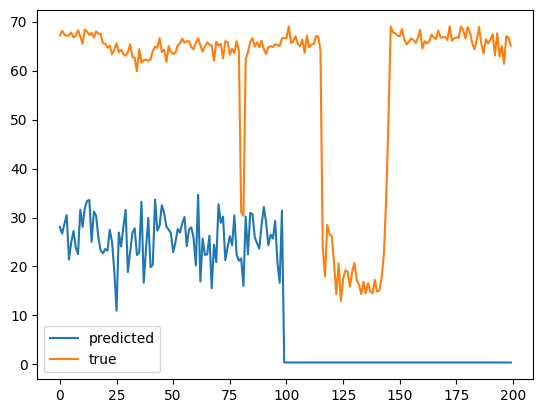

In [36]:
plt.plot(prediction[:, 0, 0], label='predicted')
plt.plot(input[:, 0, 0], label='true')
plt.legend()
plt.show()

In [37]:
prediction = prediction.reshape(prediction.shape[0], prediction.shape[-2])

In [38]:
import pandas as pd

cols = dataset.dataframe().columns.droplevel('channels')
df = pd.DataFrame(prediction, columns=cols)

In [39]:
df

nodes,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,28.073807,21.050718,25.615086,22.805309,16.472633,20.130510,21.787645,32.502831,5.557146,16.728531,...,17.103186,14.535359,29.157146,17.455721,30.521301,35.259048,18.938536,18.764339,24.140600,11.644463
1,26.708704,24.009270,25.270027,23.330400,21.637375,23.207148,21.406084,28.449907,5.164621,21.284369,...,16.750813,21.290792,24.744658,24.806301,27.414057,35.476784,18.315142,22.285044,25.612513,18.700737
2,28.710939,19.946142,19.587006,19.286718,15.339648,19.596930,19.841349,26.659399,3.515786,17.224907,...,15.396502,17.158361,29.283554,16.899303,29.714811,36.075874,18.370687,14.629882,25.091135,15.988507
3,30.465958,18.686714,19.978132,24.668549,21.619732,23.726181,20.848043,25.082499,5.891759,13.619988,...,11.126047,17.097353,31.619936,15.839975,28.188246,21.846148,18.431005,12.866557,25.112270,16.435955
4,21.422564,21.430054,24.570566,16.357168,16.921690,20.509060,14.801729,20.483194,4.800473,16.184105,...,18.739092,13.017678,5.481748,17.429968,26.142357,18.892609,6.571732,21.452621,23.963528,11.351342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.405856,0.592316,0.432362,-0.323988,-1.538800,-0.263451,0.186293,0.467021,0.305291,0.282267,...,-1.280894,0.708952,0.061207,0.500958,0.628482,0.374941,0.731099,0.363812,0.644207,0.035493
196,0.405856,0.592316,0.432362,-0.323988,-1.538800,-0.263451,0.186293,0.467021,0.305291,0.282267,...,-1.280894,0.708952,0.061207,0.500958,0.628482,0.374941,0.731099,0.363812,0.644207,0.035493
197,0.405856,0.592316,0.432362,-0.323988,-1.538800,-0.263451,0.186293,0.467021,0.305291,0.282267,...,-1.280894,0.708952,0.061207,0.500958,0.628482,0.374941,0.731099,0.363812,0.644207,0.035493
198,0.405856,0.592316,0.432362,-0.323988,-1.538800,-0.263451,0.186293,0.467021,0.305291,0.282267,...,-1.280894,0.708952,0.061207,0.500958,0.628482,0.374941,0.731099,0.363812,0.644207,0.035493


In [40]:
df.to_csv('GRINMetrLAPrediction.csv', index=False)